In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG


In [3]:
transl_with_all_codons = pd.read_csv('data/extensions_TripsViz_1perGene_AUG_NearCognates.txt', sep=',')

transl_with_all_codons.columns = ['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 'len_ext', 
                                 'global_rank_ext', 'type_all_codons', 'trips_viz_link', 'Start_codon_ext', 
                                 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage_value_ext',
       'Amino acid sequence', 'Proteomics_count_ext', 'CDS_ratio']

transl_with_all_codons2 = transl_with_all_codons[['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 
                                                 'global_rank_ext', 'Start_codon_ext', 
                                                 'Proteomics_count_ext', 'Coverage_value_ext', 'CDS_ratio']]

transl_with_all_codons2['Riboseq_Summary'] = transl_with_all_codons2['Start_codon_ext']+'; '+transl_with_all_codons2['Start_ext'].astype(str)+'-'+transl_with_all_codons2['Stop_ext'].astype(str)+'; Rank: '+transl_with_all_codons2['global_rank_ext'].astype(str)+'; cov: '+np.round(transl_with_all_codons2['Coverage_value_ext'],2).astype(str)


transl_with_all_codons2[0:5]

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gene_ext,tr_id1,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary
0,ASPH,ENST00000379454,144,189,1,CTG,0.0,100.000000,1.645069,CTG; 144-189; Rank: 1; cov: 100.0
1,HSP90AA1,ENST00000216281,168,207,2,GTG,0.0,100.000000,3.081078,GTG; 168-207; Rank: 2; cov: 100.0
2,CD24,ENST00000619133,408,441,3,CTG,0.0,83.333333,11.578498,CTG; 408-441; Rank: 3; cov: 83.33
3,HN1,ENST00000409753,242,287,4,TTG,0.0,100.000000,0.588389,TTG; 242-287; Rank: 4; cov: 100.0
4,YBX1,ENST00000321358,44,140,5,CTG,0.0,85.185185,7.709763,CTG; 44-140; Rank: 5; cov: 85.19


In [4]:
all_genes = list(metadata_pc_g25.gene.unique())
len(all_genes)

20330

In [5]:
transl_with_all_codons2[['gene_ext', 'global_rank_ext']]

,gene_ext,global_rank_ext
0,ASPH,1
1,HSP90AA1,2
2,CD24,3
3,HN1,4
4,YBX1,5
...,...,...
10466,CELF2,10467
10467,ECHS1,10468
10468,TRIM16L,10469
10469,FBXO42,10470


# (1) Get distribution of all random overlsp for 60 and 392 gene sets 

In [6]:
from random import sample

n_iterations = 20000

random_ovlp_all_genes = [len(set(sample(all_genes,60)).intersection(sample(all_genes,392))) for i in range(0, n_iterations)]

In [7]:
random_ovlp_all_genes = [len(set(P_Set.gene.tolist()).intersection(sample(all_genes,392))) for i in range(0, n_iterations)]

In [8]:
random_ovlp_all_genes

[4,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 3,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 4,
 1,
 1,
 1,
 2,
 3,
 2,
 0,
 4,
 3,
 2,
 3,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 4,
 2,
 5,
 4,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 3,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 3,
 1,
 3,
 1,
 2,
 2,
 2,
 1,
 0,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 4,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 3,
 5,
 1,
 1,
 0,
 1,
 3,
 3,
 3,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 3,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 3,
 4,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 3,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 3,


In [9]:
set(sample(all_genes,60)).intersection(sample(all_genes,392))

set()

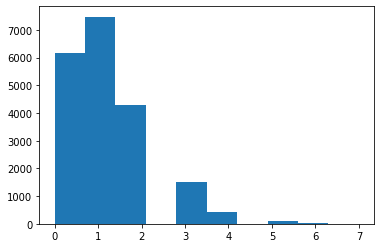

In [10]:
plt.hist(random_ovlp_all_genes)
plt.show()

In [11]:
np.mean(random_ovlp_all_genes), np.median(random_ovlp_all_genes)

(1.14735, 1.0)

In [12]:
len(sample(all_genes,392)), len(sample(all_genes,60))

(392, 60)

In [13]:
np.mean(random_ovlp_all_genes), np.median(random_ovlp_all_genes)

(1.14735, 1.0)

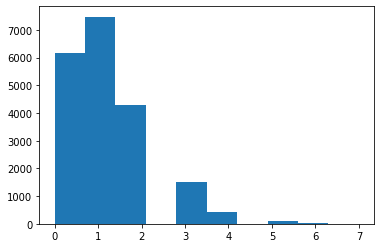

In [14]:
plt.hist(random_ovlp_all_genes)
plt.show()

# Ovlp depending on threshold 

In [15]:
tmp = transl_with_all_codons2[['gene_ext', 'global_rank_ext']]

tmp[0:2]

,gene_ext,global_rank_ext
0,ASPH,1
1,HSP90AA1,2


In [16]:
def get_ovlp(thr=500):
    return len(set(tmp[0:thr]['gene_ext'].tolist()).intersection(list(P_Set['gene'].unique())))

(-1.0, 45.0)

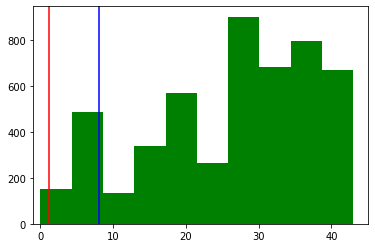

In [17]:
plt.hist([get_ovlp(thr=thr) for thr in range(1, 5000)], color='green')

plt.axvline(x=np.mean(random_ovlp_all_genes), color='red')

plt.axvline(x=8, color='blue')

plt.xlim(-1, 45)

In [18]:
get_ovlp(thr=7)

1

"H0: The probability of selecting TS genes is no lower than random selection from the population" and the alternative, 
"H1: The probability of selecting TS genes is lower than random selection from the population".

(-1.0, 45.0)

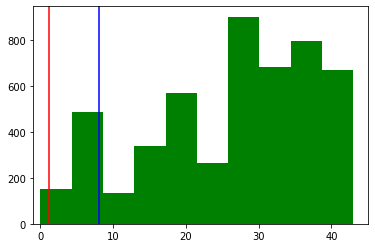

In [19]:
plt.hist([get_ovlp(thr=thr) for thr in range(1, 5000)], color='green')

plt.axvline(x=np.mean(random_ovlp_all_genes), color='red')

plt.axvline(x=8, color='blue')

plt.xlim(-1, 45)

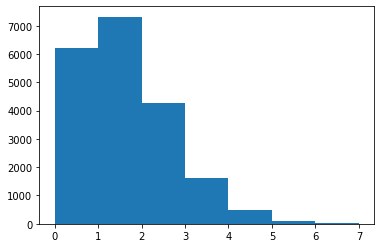

In [20]:
plt.hist(random_ovlp_all_genes, bins=7)
plt.show()

# Hypergeom test : to show that ovlp between two samples is greater than from 2 indepent samples (drawn randomly from population)

In [21]:
from scipy.stats import hypergeom

# M = 20000 population of genes 
# n = 60 phyloset 
# N = 392 - riboset

# what ovlp we expect 

[M, n, N] = [20000, 60, 392]

x = 8 # ovlp between groupd we see


# cumulative, X
prb = hypergeom.cdf(x, M, n, N)

prb

0.9999976187587246

In [22]:
k=8

hypergeom.pmf(k, M, n, N, loc=0)

1.8918364256958717e-05

In [23]:
k=get_ovlp(thr=110)
[M, n, N] = [20000, 60, 392]

hypergeom.pmf(k, M, n, N, loc=0)

0.023624827939919293

# 60 genes and 500 genes; 60 genes and 550 genes

In [24]:
def get_ovlp(thr=500):
    if thr <= 10470:
        return len(set(tmp[0:thr]['gene_ext'].tolist()).intersection(list(P_Set['gene'].unique())))
    else: 
        return len(set(tmp[0:10470]['gene_ext'].tolist()).intersection(list(P_Set['gene'].unique())))

In [25]:
ranked_based_ovlps = [get_ovlp(thr=thr) for thr in range(100, 19000, 100)]

random_ovlps =  [len(set(P_Set.gene.tolist()).intersection(sample(all_genes, i))) for i in range(100, 19000, 100)]

axis_x = list(range(100, 19000, 100))

print (random_ovlps[0:5])

print (ranked_based_ovlps[0:5])

[0, 0, 1, 3, 1]
[3, 5, 6, 8, 8]


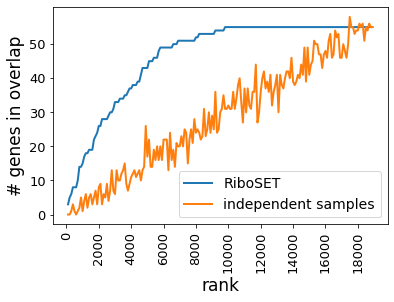

In [26]:
plt.plot(axis_x, ranked_based_ovlps, linewidth=2, markersize=12, label='RiboSET')

plt.plot(axis_x, random_ovlps, linewidth=2, markersize=12, label='independent samples')

plt.yticks(list(range(0, 60, 10)), list(range(0, 60, 10)), fontsize=13)
plt.xticks(list(range(0, 19000, 2000)), list(range(0, 19000, 2000)), fontsize=13, rotation=90)

plt.xlabel('rank', fontsize=17)

plt.ylabel('# genes in overlap', fontsize=17)

plt.legend(loc=0, prop={'size': 14})

plt.show()

# Plot increment 

In [27]:
random_ovlps =  [len(set(P_Set.gene.tolist()).intersection(sample(all_genes, i))) for i in range(0, 10500, 500)]

In [28]:
random_ovlps = []

for i in range(0, 10500, 500):
    kek_li = []
    for iter in range(0, 1000):
        kek = len(set(P_Set.gene.tolist()).intersection(sample(all_genes, i)))
        kek_li.append(kek)
        
    mean_kek = np.mean(kek_li)
    random_ovlps.append(mean_kek)
    
random_ovlps

[0.0,
 1.428,
 3.021,
 4.348,
 5.81,
 7.481,
 8.837,
 10.337,
 11.675,
 13.296,
 14.821,
 16.256,
 17.916,
 19.137,
 20.631,
 22.318,
 23.728,
 24.951,
 26.683,
 28.051,
 29.499]

In [29]:
ranked_based_ovlps = [get_ovlp(thr=thr) for thr in range(0, 10500, 500)]

#random_ovlps =  [len(set(P_Set.gene.tolist()).intersection(sample(all_genes, i))) for i in range(0, 10500, 500)]


x = np.arange(0, 20, 1)
axis_x = list(range(0, 10500, 500))

axis_x1 = [(axis_x[i], axis_x[i+1]) for i in range(0, len(axis_x)-1)]

print (random_ovlps[0:5])

print (ranked_based_ovlps[0:5])

a = [ranked_based_ovlps[i+1]-ranked_based_ovlps[i] for i in range(0, len(ranked_based_ovlps)-1)]

b = [random_ovlps[i+1]-random_ovlps[i] for i in range(0, len(random_ovlps)-1)]

[0.0, 1.428, 3.021, 4.348, 5.81]
[0, 8, 15, 19, 26]


In [30]:
len(axis_x1), len(a), len(b), len(x)

(20, 20, 20, 20)

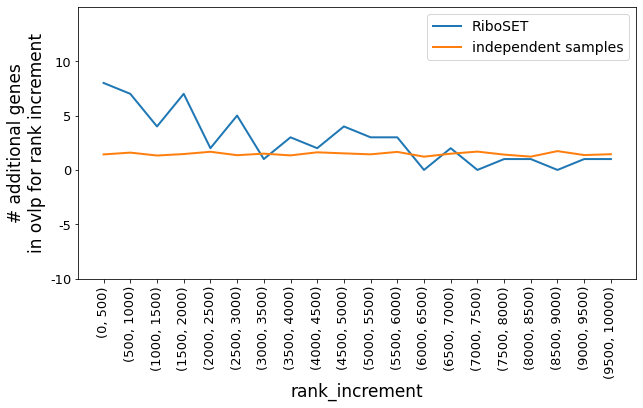

In [31]:
plt.figure(figsize=(10, 5))


plt.plot(x, a, linewidth=2, markersize=12, label='RiboSET')

plt.plot(x, b, linewidth=2, markersize=12, label='independent samples')

plt.yticks(list(range(-10, 15, 5)), list(range(-10, 15, 5)), fontsize=13)
plt.xticks(x, axis_x1, fontsize=13, rotation=90)

plt.xlabel('rank_increment', fontsize=17)

plt.ylabel('# additional genes\nin ovlp for rank increment', fontsize=17)

plt.legend(loc=0, prop={'size': 14})

plt.ylim(-10, 15)


plt.show()

In [241]:
step = 1000

ranked_based_ovlps = [get_ovlp(thr=thr) for thr in range(0, 10500, step)]

random_ovlps =  [len(set(P_Set.gene.tolist()).intersection(sample(all_genes, i))) for i in range(0, 10500, step)]


x = np.arange(0, 10, 1)
axis_x = list(range(0, 10500, step))

axis_x1 = [(axis_x[i], axis_x[i+1]) for i in range(0, len(axis_x)-1)]

print (random_ovlps[0:5])

print (ranked_based_ovlps[0:5])

a = [ranked_based_ovlps[i+1]-ranked_based_ovlps[i] for i in range(0, len(ranked_based_ovlps)-1)]

b = [random_ovlps[i+1]-random_ovlps[i] for i in range(0, len(random_ovlps)-1)]

len(axis_x1), len(a), len(b), len(x)

[0, 1, 4, 10, 10]
[0, 15, 26, 33, 37]


(10, 10, 10, 10)

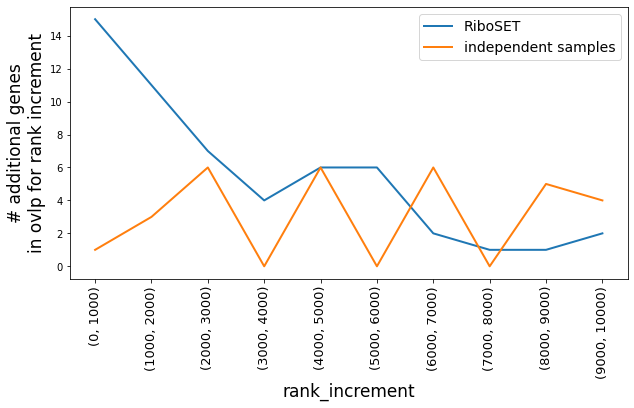

In [244]:
plt.figure(figsize=(10, 5))


plt.plot(x, a, linewidth=2, markersize=12, label='RiboSET')

plt.plot(x, b, linewidth=2, markersize=12, label='independent samples')

#plt.yticks(list(range(-10, 15, 5)), list(range(-10, 15, 5)), fontsize=13)
plt.xticks(x, axis_x1, fontsize=13, rotation=90)

plt.xlabel('rank_increment', fontsize=17)

plt.ylabel('# additional genes\nin ovlp for rank increment', fontsize=17)

plt.legend(loc=0, prop={'size': 14})

#plt.ylim(-10, 15)


plt.show()

# 500-> 1000 hypergeom test 

In [200]:
get_ovlp(thr=500), get_ovlp(thr=1000)

(8, 15)

In [202]:
len(set(P_Set.gene.tolist()).intersection(sample(all_genes, 500))), len(set(P_Set.gene.tolist()).intersection(sample(all_genes, 1000)))

(1, 4)

In [ ]:
      RiboSET independent 
'500'    8        1
'1000'   15       4

In [204]:
get_ovlp(thr=1000), get_ovlp(thr=1500)

(15, 19)

In [205]:
len(set(P_Set.gene.tolist()).intersection(sample(all_genes, 1000))), len(set(P_Set.gene.tolist()).intersection(sample(all_genes, 1500)))

(4, 3)

In [ ]:
      RiboSET independent 
'1000'   15        4
'1500'   19        3

In [206]:
get_ovlp(thr=1500), get_ovlp(thr=2000)

(19, 26)

In [207]:
len(set(P_Set.gene.tolist()).intersection(sample(all_genes, 1500))), len(set(P_Set.gene.tolist()).intersection(sample(all_genes, 2000)))

(9, 5)

In [ ]:
      RiboSET independent 
'1500'   19        9
'2000'   26        5

# 9 genes that have translated CDS but no extensions and still have PCSF > 0 

In [50]:
P_Set[P_Set['gene'].isin(['ENY2', 'UBE2A', 'TAF12', 'KIAA0930', 
                         'GLTP', 'SULT1A1', 'FBXW7',
                         'SMAD7', 'CACNG8'])][['gene', 'tr_id', 'PhyloCSF120score',
                                               'global_coo_primary', 
                                               'strand', 'global_coo_50_and_less']]

,gene,tr_id,PhyloCSF120score,global_coo_primary,strand,global_coo_50_and_less
3,TAF12,ENST00000373824.8,327.9236,chr1:28622082-28622165+chr1:28642992-28643003,-,chr1:28622082-28622165+chr1:28642992-28643003
21,FBXW7,ENST00000603841.1,52.0127,chr4:152411804-152411878,-,chr4:152411804-152411878
28,ENY2,ENST00000521688.5,15.0202,chr8:109334373-109334468,+,chr8:109334373-109334468
38,GLTP,ENST00000318348.8,24.8281,chr12:109880375-109880488,-,chr12:109880375-109880488
43,SULT1A1,ENST00000350842.8,36.6149,chr16:28623198-28623314,-,chr16:28623198-28623314
58,SMAD7,ENST00000262158.6,41.0208,chr18:48950425-48950709,-,chr18:48950425-48950574
62,CACNG8,ENST00000270458.2,171.2583,chr19:53963041-53963142,+,chr19:53963041-53963142
74,KIAA0930,ENST00000336156.9,69.9328,chr22:45240704-45240769,-,chr22:45240704-45240769
81,UBE2A,ENST00000371558.6,640.8192,chrX:119574469-119574711,+,chrX:119574562-119574711
82,UBE2A,ENST00000346330.6,640.8192,chrX:119574538-119574711,+,chrX:119574562-119574711


# CDS_cov VS RANK 

In [121]:
li = []

for el in P_Set[['tr_id', 'Riboseq_Summary']].to_numpy():
    tr_id = el[0]
    summary = el[1]
    if summary is np.nan:
        rank = 8000
    else:
        rank = int(summary.split('Rank: ')[1].split(';')[0])

    li.append([tr_id, rank, summary])
    
df = pd.DataFrame(li, columns = ['tr_id', 'rank', 'summary'])

P_Set2 = P_Set.merge(df, on='tr_id', how='inner')

P_Set2[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,rank,summary
0,ENST00000377898.3,HES3,2,65,21.0,chr1:6244194-6244241+chr1:6244351-6244365,+,chr1:6244194-6244241+chr1:6244351-6244365,210.1621,118,0;0;0,ACG; 6-66; Rank: 1907; cov: 40.0,40.0,0.0,"basic,appris_principal_1,CCDS",protein_coding,1907,ACG; 6-66; Rank: 1907; cov: 40.0
1,ENST00000400907.6,RERE,2,74,24.0,chr1:8656298-8656369,-,chr1:8656298-8656369,108.1564,119,0;0;0,NaN,NaN,NaN,"not_organism_supported,dotter_confirmed,basic",protein_coding,8000,NaN


In [122]:
li = []

for el in P_Set2[['gene', 'tr_id', 'rank']].to_numpy():
    rank = el[2]
    gene = el[0]
    tr_id = el[1].split('.')[0]
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos 
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    frame = ((cds_start_pos) % 3) + 1
    cds_len = cds_stop_pos - cds_start_pos
    
    if len(glob.glob('data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id))) != 0:  
        file_counts = pd.read_csv('data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id))
        CDS_counts = file_counts[cds_start_pos:cds_stop_pos]['Frame '+str(frame)].sum()
        CDS_coverage = CDS_counts / cds_len
    else:
        CDS_coverage = 0
        
    
    
    
    
    #print ('frame 1', file_counts[cds_start_pos:cds_stop_pos]['Frame 1'].sum())
    #print ('frame 2', file_counts[cds_start_pos:cds_stop_pos]['Frame 2'].sum())
    #print ('frame 3', file_counts[cds_start_pos:cds_stop_pos]['Frame 3'].sum())
    #print ('cds_frame', frame)
    
    li.append([gene, tr_id, cds_len, CDS_coverage, rank])

In [123]:
plot_df = pd.DataFrame(li, columns = ['gene', 'tr_id', 'cds_len', 'CDS_coverage', 'rank'])

plot_df[0:2]

,gene,tr_id,cds_len,CDS_coverage,rank
0,HES3,ENST00000377898,561,4.606061,1907
1,RERE,ENST00000400907,1755,3.852422,8000


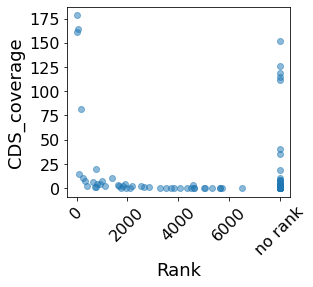

In [133]:
plt.figure(figsize=(4,3.5))

plt.scatter(y=plot_df['CDS_coverage'].tolist(), 
            x=plot_df['rank'].tolist(), alpha=0.5)

plt.xticks(range(0, 9000, 2000), [0, 2000, 4000, 6000, 'no rank'], fontsize=16, rotation=45)
plt.yticks(fontsize=16)

plt.xlabel('Rank', fontsize=18)
plt.ylabel('CDS_coverage', fontsize=18)

plt.show()